In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('dark')

# ====== Scikit-learn imports ======

from sklearn.svm import SVC
from sklearn.metrics import (
    auc,
    roc_curve,
    ConfusionMatrixDisplay,
    f1_score,
    balanced_accuracy_score,
)
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

# ====== Qiskit imports ======

from qiskit.circuit.library import ZZFeatureMap
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_algorithms.optimizers import COBYLA

## ====== Torch imports ======
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from lightning.pytorch.utilities.types import OptimizerLRScheduler
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader

import lightning, lightning.pytorch.loggers


In [3]:
df = pd.read_csv("/dccstor/boseukb/CuNA/data/GSE116237_QCed.csv")
labels = pd.read_csv("/dccstor/boseukb/CuNA/data/GSE116237 filtered labels.csv")
labels.drop('Unnamed: 0', axis=1, inplace=True)
labels.columns = ['Cells', 'Labels']
labels_filtered = labels[labels['Cells'].isin(list(df['Cells']))]
labels_filtered['Labels'] = [x.split(' ')[1] for x in labels_filtered['Labels']]
df = pd.merge(df, labels_filtered, on='Cells', how='inner')
df['Labels'] = df['Labels'].map({'T0': 0, 'phase2': 1})
y = np.array(df['Labels'])
X = df[df.columns[1:-1]].values

num_samples = X.shape[0]
num_feats = X.shape[1]
output_dim = 10

/tmp/ipykernel_2920575/609488735.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_filtered['Labels'] = [x.split(' ')[1] for x in labels_filtered['Labels']]


In [4]:
embedder = torch.nn.Sequential(
            nn.Linear(num_feats,256),
            nn.LeakyReLU(),
            nn.Linear(256,64),
            nn.LeakyReLU(),
            nn.Linear(64,32), 
            nn.LeakyReLU(),
            nn.Linear(32,16), 
            nn.LeakyReLU(),
            nn.Linear(16,output_dim),
            nn.LeakyReLU(), 
            ) 

classifier = torch.nn.Sequential(
            nn.Linear(output_dim,1),
            nn.Softmax(dim=1)
            )
class BinaryClassifierModel(lightning.LightningModule):
    def __init__(self, embedder, classifier, input_dim,learning_rate=1e-3):
        super().__init__()
        # self.fc1 = nn.Linear(input_dim, 264)
        # self.fc2 = nn.Linear(264, 128)
        # self.fc3 = nn.Linear(128, 64)
        # self.fc4 = nn.Linear(64, 8)
        # self.fc5 = nn.Linear(8,4)
        # self.fc6 = nn.Linear(4,1)
        self.input_dim = input_dim
        self.embedder = embedder
        self.classifier = classifier
        
        self.learning_rate = learning_rate
        self.loss_fun = nn.BCELoss()   
    # def forward(self, x):
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = F.relu(self.fc3(x))
    #     x = F.relu(self.fc4(x))
    #     x = F.relu(self.fc5(x))
    #     return F.softmax(self.fc6(x), dim=1)
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=32)  # No shuffling for validation
    
    def forward(self, X): 
        x = self.embedder(X)
        x = self.classifier(x) 
        return x 
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1)
        y_float = y.float()
        x_embedder = self.embedder(x)
        y_hat = self.classifier(x_embedder)
        #y_hat = torch.argmax(y_hat, dim=1)
        loss = self.loss_fun(y_hat, y_float)
        self.log("train_loss", loss, 
                prog_bar=True, 
                logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1)
        y_float = y.float()
        x_embedder = self.embedder(x)
        y_hat = self.classifier(x_embedder)
        val_loss = self.loss_fun(y_hat, y_float)
        f1score = f1_score(y_hat, y)
        print(f1score)
        #print(val_loss)
        self.log("val_loss", val_loss, prog_bar=False, logger=True)  # Log on epoch end
        return val_loss

        
    def configure_optimizers(self):
        return torch.optim.Adam(self.classifier.parameters(), lr=self.learning_rate)

        

In [5]:
def prepare_data(X_train, y_train, X_val, y_val):
    # Assuming X and y are NumPy arrays

    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                        torch.tensor(y_train, dtype=torch.float32))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                        torch.tensor(y_val, dtype=torch.float32))
    
    return train_data, val_data 

In [6]:
f1s = []
embeddings_train = []
embeddings_test = []
num_iter = 1
for i in range(num_iter): 

    X_working, X_held_out, y_working, y_held_out = train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        shuffle=True)

    X_train, X_test, y_train, y_test = train_test_split(X_working,
                                                        y_working,
                                                        train_size=0.9,
                                                        shuffle=True)

    num_epochs = 40
    model = BinaryClassifierModel(embedder, classifier, input_dim=num_feats)
    model.train_data, model.val_data = prepare_data(X_train, y_train, X_test, y_test)  # Prepare data for training
    logger = lightning.pytorch.loggers.TensorBoardLogger(save_dir=".",name="original_classifier")
    # Train the model
    trainer = lightning.Trainer(max_epochs=num_epochs, 
                                logger=logger)  # Adjust progress bar refresh rate as needed
    trainer.fit(model)
    model.eval()
    embedded_test = model.embedder(torch.tensor(X_held_out, dtype=torch.float32))
    y_pred = model.classifier(embedded_test)
    #y_pred = model(torch.tensor(X_held_out, dtype=torch.float32))
    y_pred_proba = y_pred.detach().cpu().numpy()
    y_pred_class = np.round(y_pred_proba)

    f1 = f1_score(y_held_out, y_pred_class)
    f1s.append(f1)
    
    embedded_train = model.embedder(torch.tensor(X_working, dtype=torch.float32)).detach().numpy()
    embeddings_train.append(embedded_train)
    embeddings_test.append(embedded_test.detach().numpy())
    

print("Mean F1 score: ", np.mean(f1s))
embedded_train = embeddings_train[0]
embedded_test = embeddings_test[0]
svc = SVC()
svc_vanilla = svc.fit(embedded_train, y_working)
labels_vanilla = svc_vanilla.predict(embedded_test)
f1_svc = f1_score(y_held_out, labels_vanilla, average='micro')
print("SVC: " + str(f1_svc))

    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-05-23 09:13:49.240372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

  | Name       | Type       | Params
------------------------------------------
0 | embedder   | Sequential | 531 K 
1 | classifier | Sequential | 11    
2 | loss_fun   | BCELoss    | 0     
------------------------------------------
531 K     Trainable params
0         Non-trainable params
531 K     Total params
2.126     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/dccstor/boseukb/conda/Q/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]0.7755102040816326


/dccstor/boseukb/conda/Q/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/dccstor/boseukb/conda/Q/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 15.78it/s, v_num=229, train_loss=66.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]0.7755102040816326

Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 31.34it/s, v_num=229, train_loss=55.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]0.7755102040816326

Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 34.04it/s, v_num=229, train_loss=77.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]0.7755102040816326

Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 32.82it/s, v_num=229, train_loss=44.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]0.7755102040816326

Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 30.07it/s, v_num=229, train_loss=66.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 9/9 [00:00<00:00, 28.04it/s, v_num=229, train_loss=55.60]
Mean F1 score:  0.7241379310344828
SVC: 0.5945945945945946


In [18]:
print(np.mean(f1s))
c = 10 
embedded_train = embeddings_train[0]
embedded_test = embeddings_test[0]
svc = SVC(C=c)
svc_vanilla = svc.fit(embedded_train, y_working)
labels_vanilla = svc_vanilla.predict(embedded_test)
f1_svc = f1_score(y_held_out, labels_vanilla, average='micro')
print("SVC: " + str(f1_svc))


0.7241379310344828
SVC: 0.7027027027027027


In [20]:
service = QiskitRuntimeService(instance="accelerated-disc/internal/default") 
backend = service.least_busy(simulator=False, operational=True) 
#backend = AerSimulator(method='statevector')
algorithm_globals.random_seed = 12345
feature_map = ZZFeatureMap(feature_dimension=num_feats, 
                                reps=3, 
                                entanglement='linear', 
                                insert_barriers=True)
sampler = Sampler() 
fidelity = ComputeUncompute(sampler=sampler)
Qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
qsvc = SVC(kernel=Qkernel.evaluate, C=c)
qsvc_model = qsvc.fit(embedded_train, y_working)
labels_qsvc = qsvc_model.predict(embedded_test)
f1_qsvc = f1_score(y_held_out, labels_qsvc, average='micro')

print("QSVC: " + str(f1_qsvc))

QSVC: 0.7162162162162162


## VQC

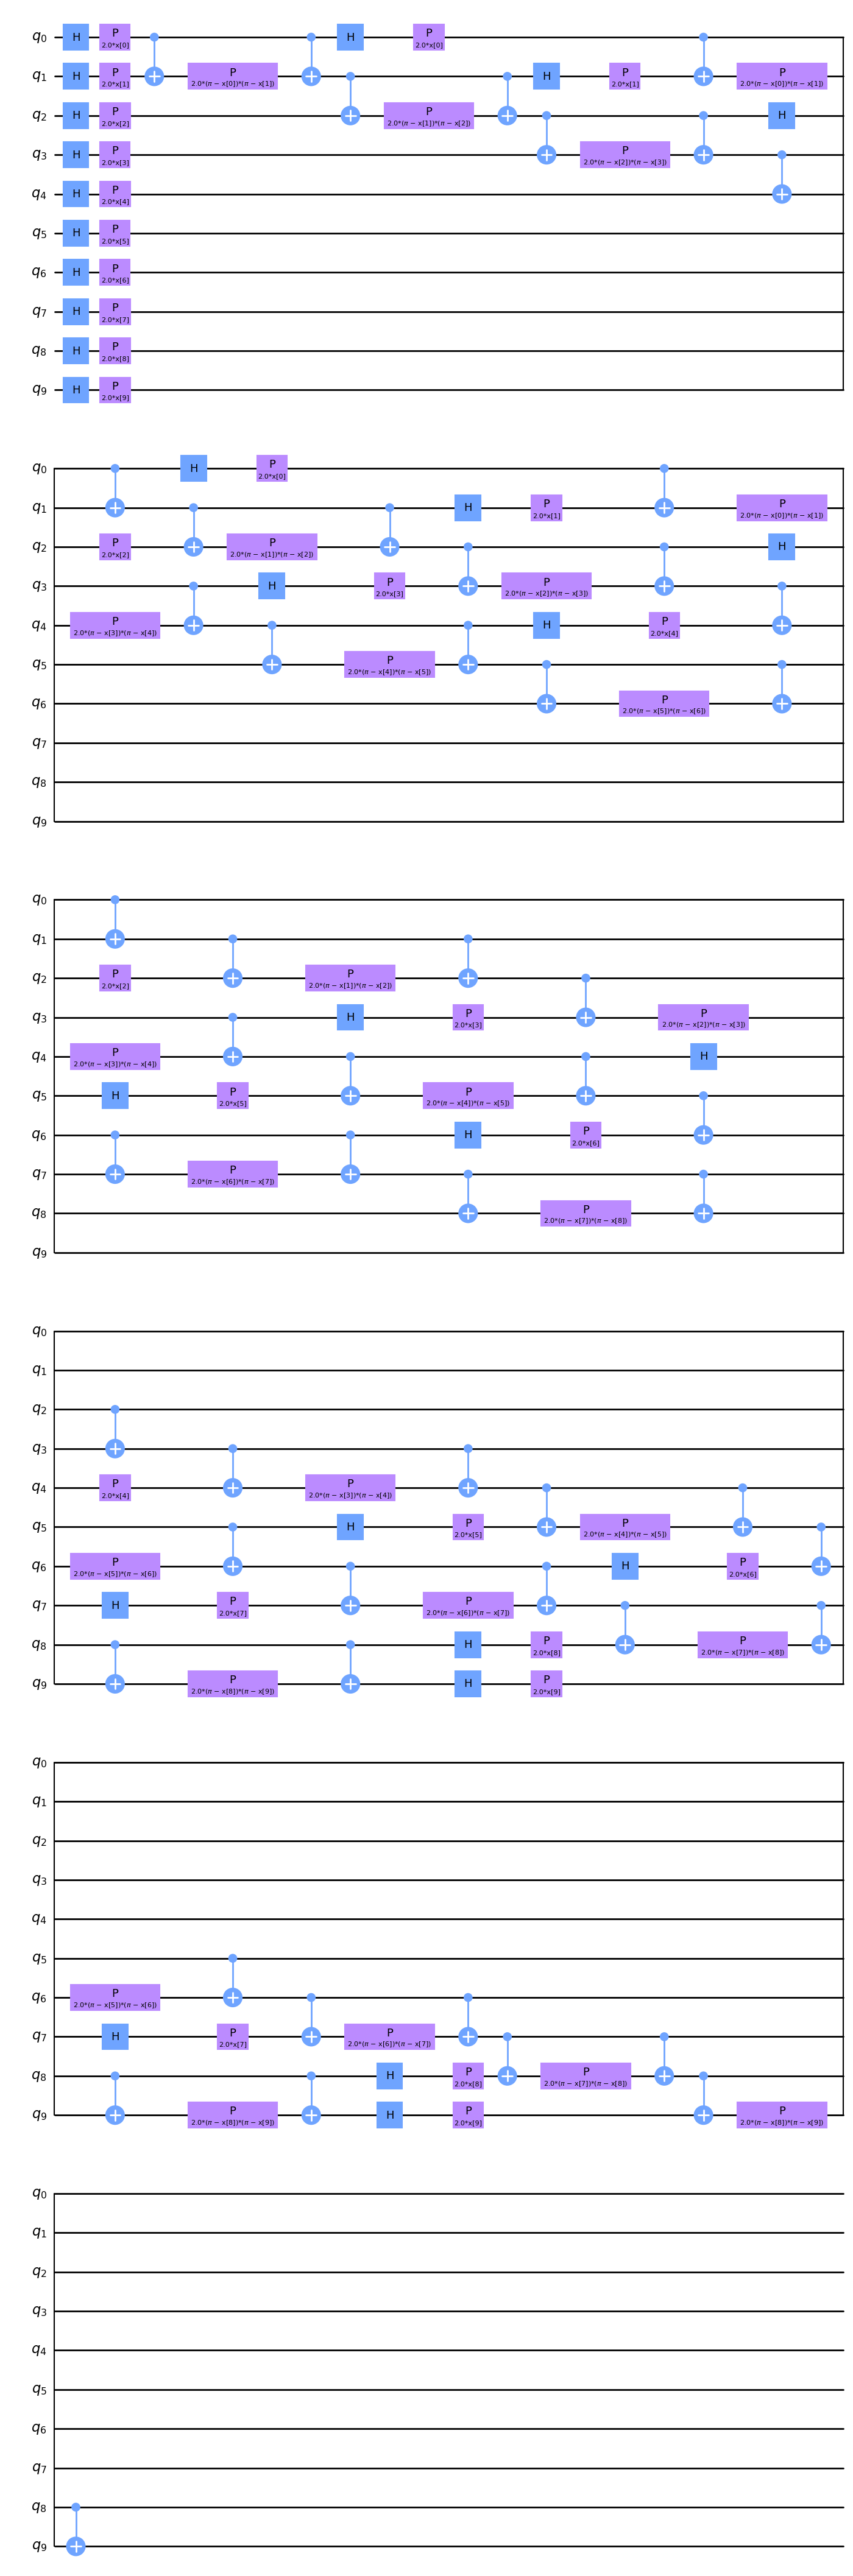

In [9]:
num_features = output_dim

feature_map = ZZFeatureMap(feature_dimension=num_features, 
                        reps=3, 
                        entanglement='linear')
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

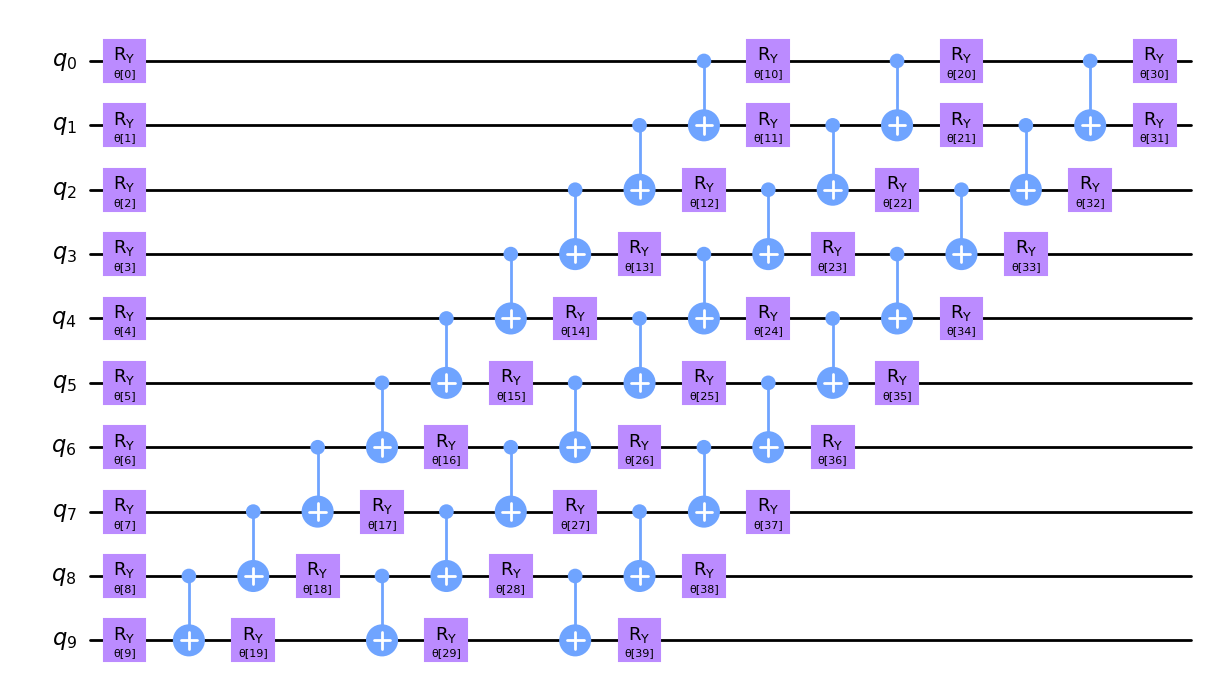

In [10]:
ansatz = RealAmplitudes(num_qubits=output_dim, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [11]:
optimizer = COBYLA(maxiter=100)
sampler = Sampler() 

from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


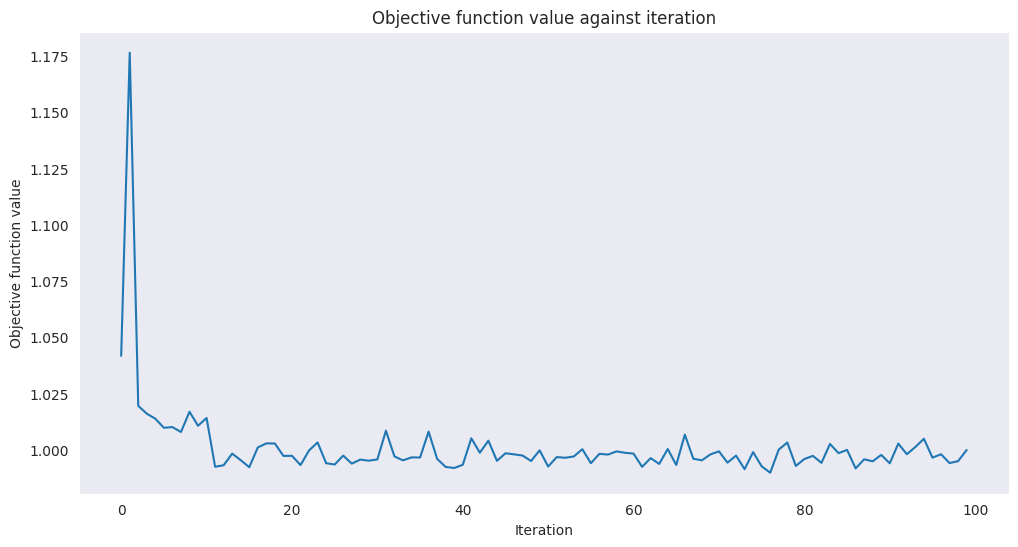

Training time: 1301 seconds


In [16]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

sampler = Sampler(options={"shots": 512})
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(embedded_train, y_working)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [17]:
train_score_q4 = vqc.score(embedded_train, y_working)
test_score_q4 = vqc.score(embedded_test, y_held_out)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")



Quantum VQC on the training dataset: 0.54
Quantum VQC on the test dataset:     0.57
